<h1> Hybrid Model Check </h1>

In [246]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150
import warnings
warnings.filterwarnings("ignore")

### importing dataset and dataset analysis

In [247]:
df = pd.read_csv("input/SDSS_dr16.csv",skiprows=0)
df = df.drop(['run','rerun','camcol','field','fiberid','specobjid','objid','mjd'],axis=1)

In [248]:
df.head()
# result is the target attribute

,ra,dec,u,g,r,i,z,class,redshift,plate
0,185.182780,1.189488,19.34126,18.46700,18.44940,18.33074,18.06268,QSO,2.627589,3846
1,216.927113,0.824043,19.20285,18.19531,17.59929,17.22163,17.02410,GALAXY,0.150541,306
2,130.183176,49.955453,18.53200,17.65095,17.24701,17.12667,17.10159,STAR,-0.000139,7311
3,146.011531,59.079110,18.68013,18.36549,18.32169,18.33179,18.27370,QSO,0.775121,453
4,190.489753,63.544891,19.15626,18.12416,17.64571,17.40442,17.13662,QSO,2.613389,781


In [249]:
df.shape

(30000, 10)

Dataset has 11055 rows and 32 column

In [250]:
df.columns

Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift', 'plate'], dtype='object')

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        30000 non-null  float64
 1   dec       30000 non-null  float64
 2   u         30000 non-null  float64
 3   g         30000 non-null  float64
 4   r         30000 non-null  float64
 5   i         30000 non-null  float64
 6   z         30000 non-null  float64
 7   class     30000 non-null  object 
 8   redshift  30000 non-null  float64
 9   plate     30000 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 2.3+ MB


### checking for null values

In [252]:
# no null values
df.isnull().sum()

ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
plate       0
dtype: int64

### checking if target class is equally balanced 

<AxesSubplot:xlabel='class', ylabel='count'>

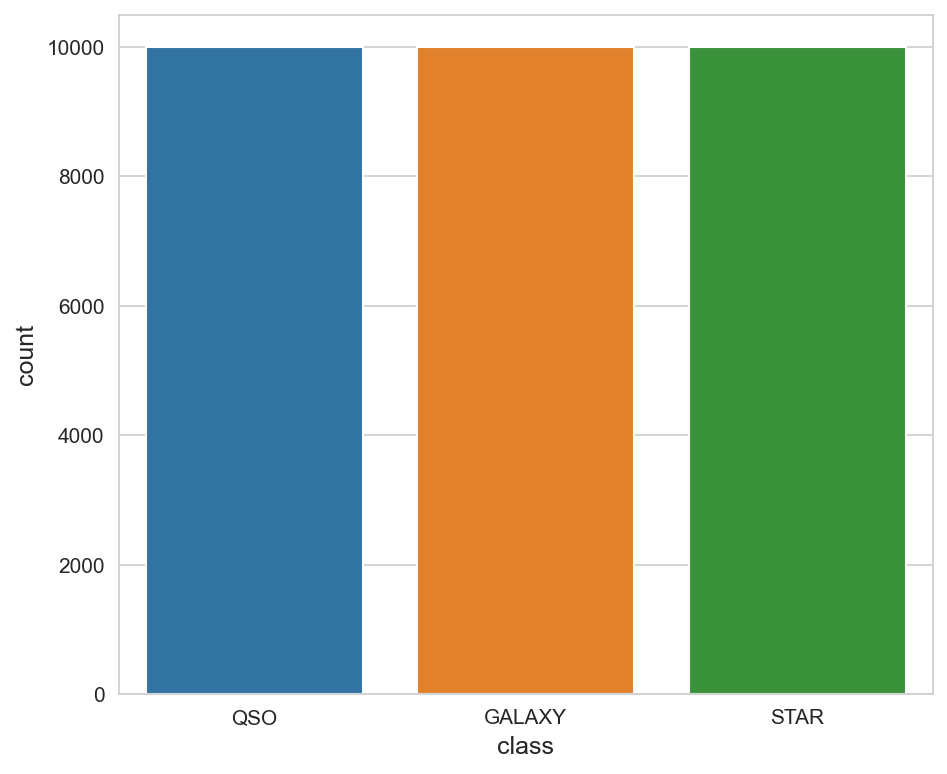

In [253]:
plt.figure(figsize=(7,6))
sns.countplot('class', data = df)

In [254]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['class'])
df['class'] = y_encoded

In [255]:
df['class'].value_counts()

1    10000
0    10000
2    10000
Name: class, dtype: int64

we can see the target class count is almost equally balanced. Hence Data augmentation is necessary

### Identifying multicollinear columns

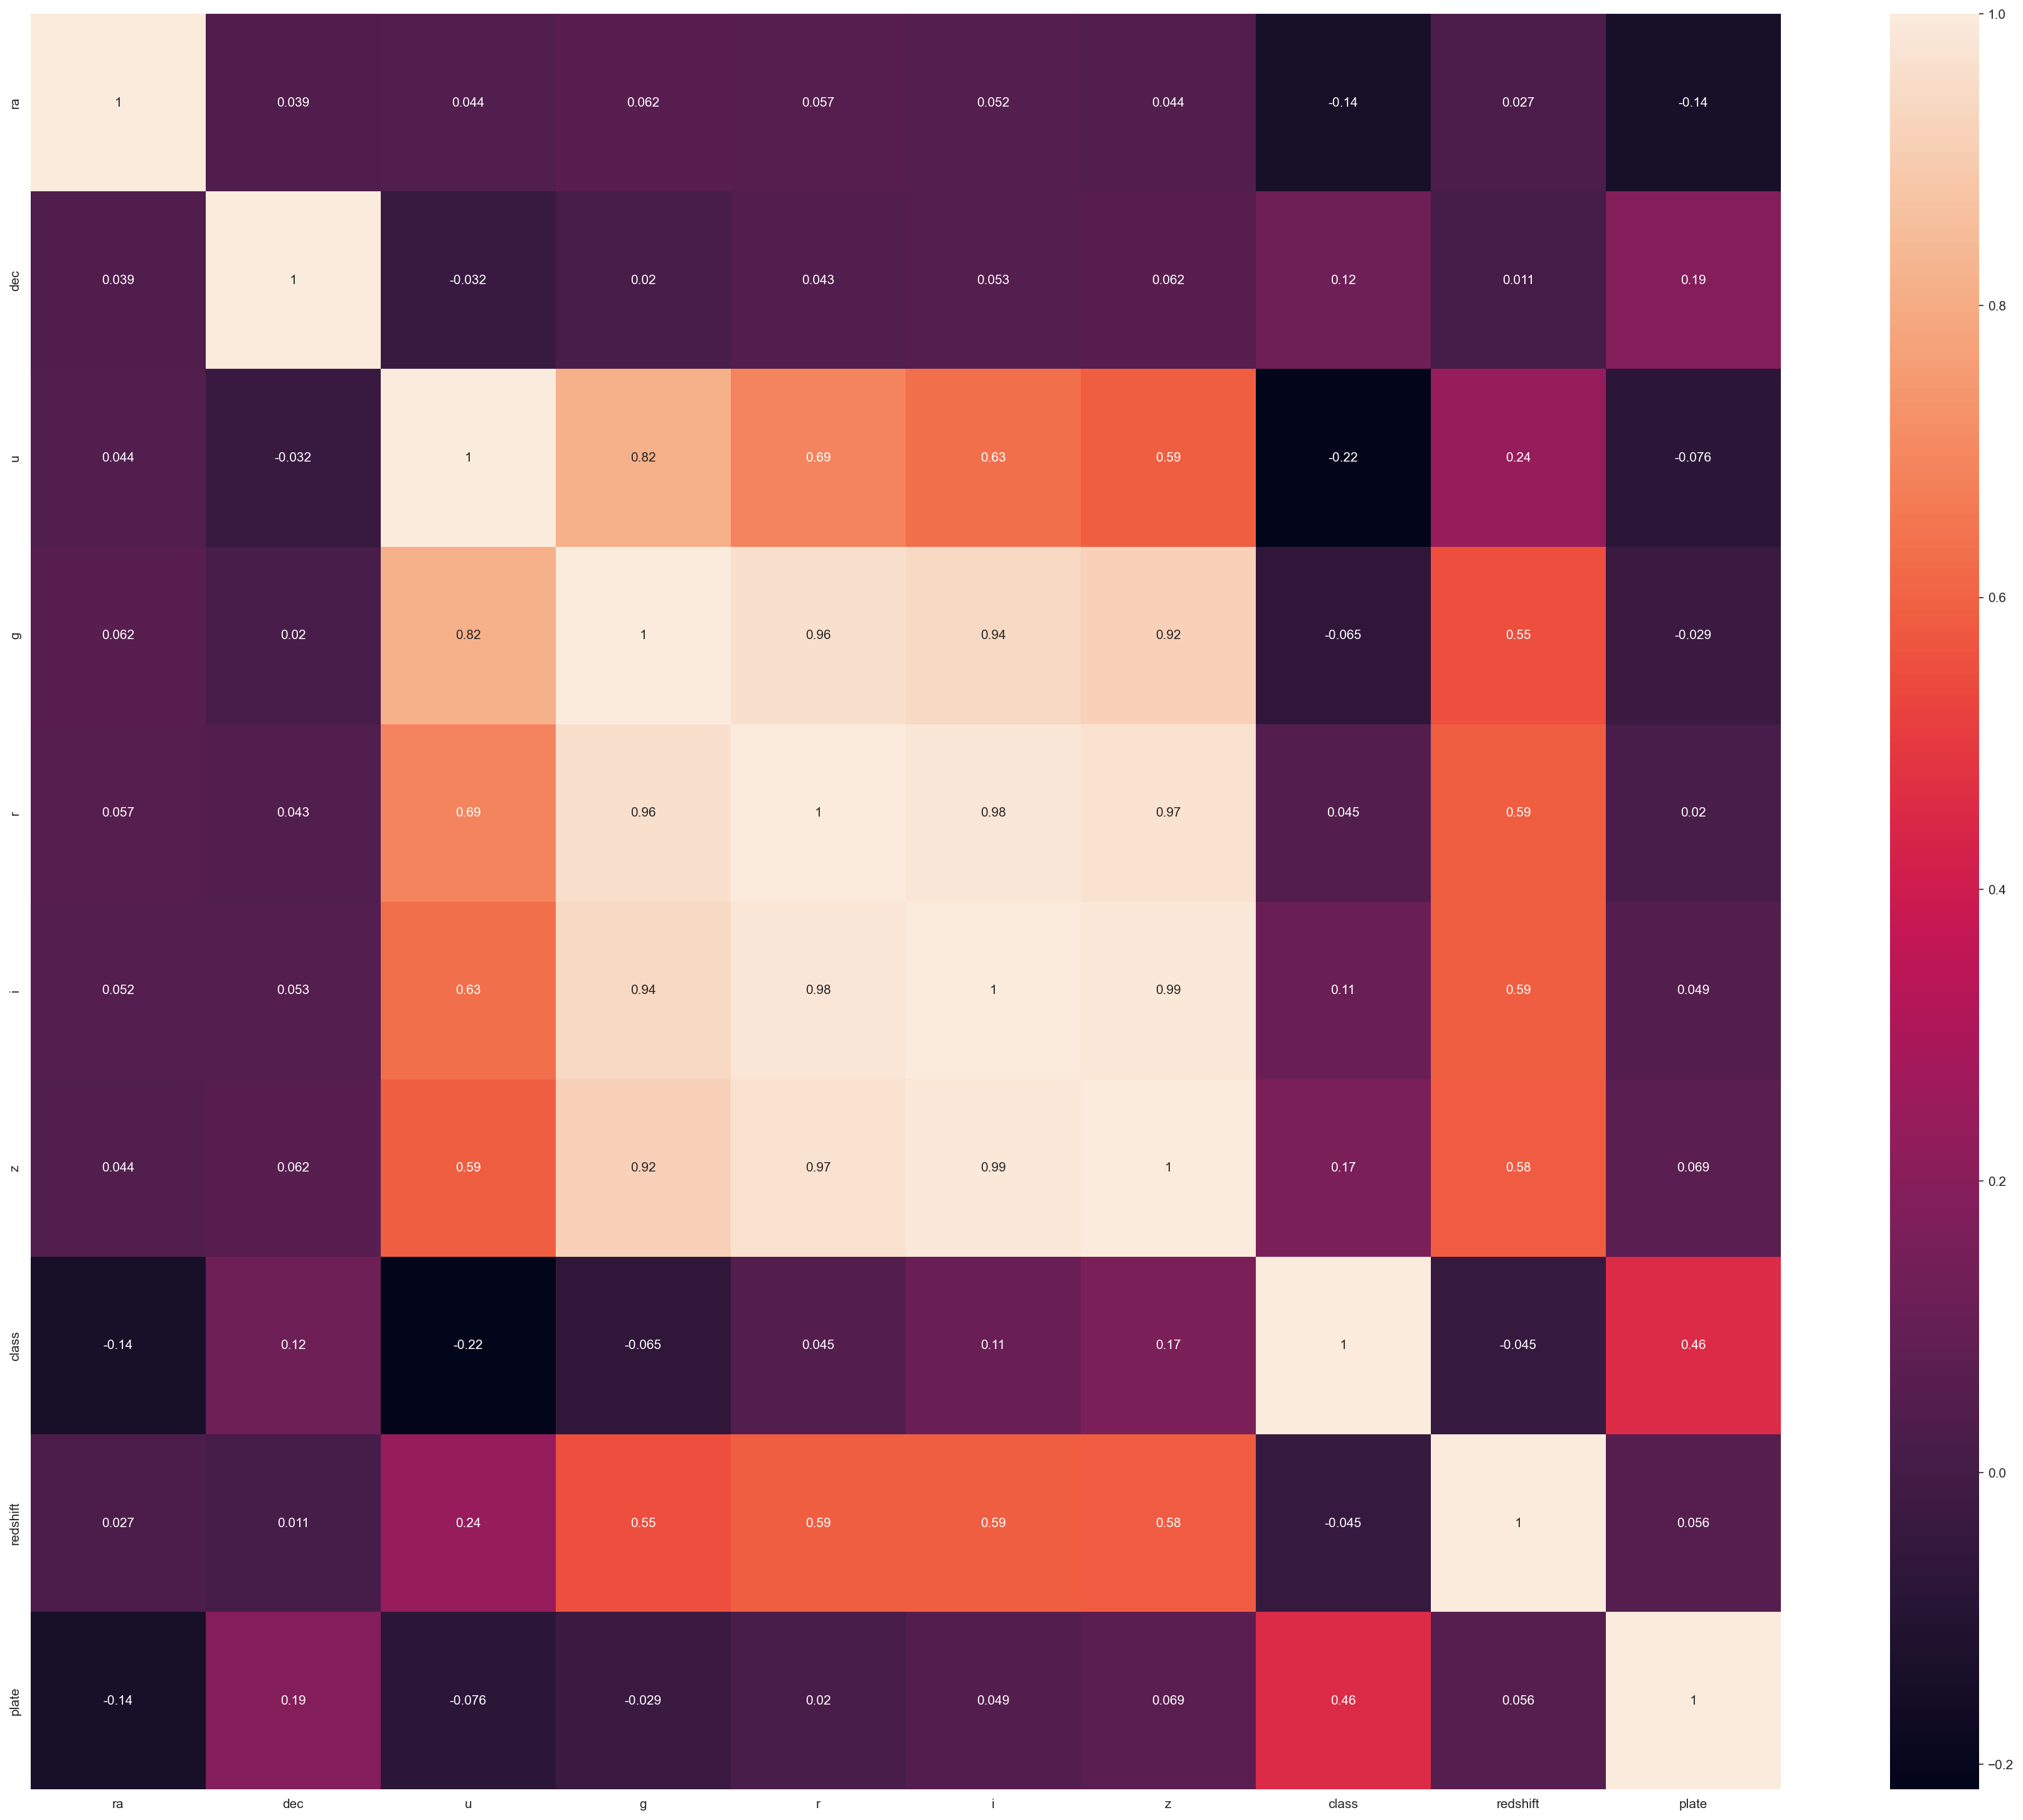

In [256]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30, 25))
g = sns.heatmap(df[top_corr_features].corr(), annot = True)

In [257]:
col_corr = set() # Set of all the names of deleted columns
def correlation(dataset, threshold):
  corr_matrix = abs(dataset.corr())
  for i in range(len(corr_matrix.columns)):
      for j in range(i):
          if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
              colname = corr_matrix.columns[i] # getting the name of column
              col_corr.add(colname)

In [258]:
# remove multicollinear column with collinearity greater than 0.85
correlation(df, 0.95)
col_corr

{'r', 'z'}

In [260]:
# identifying weakly correlated features with target attribute
weak_col_corr = set()
def weakcorrelation(dataset, threshold):
  corr_matrix = abs(dataset.corr())
  idx = 0
  for feature in corr_matrix['class']:
    if(feature < threshold):
      weak_col_corr.add(corr_matrix.columns[idx])
    idx += 1
  
 # dropping features with correlation less than 0.04
weakcorrelation(df, 0.04)
print(weak_col_corr)

set()


In [261]:
# gathering all columns that were identified to be deleted
del_col = col_corr.union(weak_col_corr)
del_col

{'r', 'z'}

In [262]:
# dropping columns permanantly
df.drop(del_col, axis = 1, inplace = True)

In [263]:
df.isnull().sum()

ra          0
dec         0
u           0
g           0
i           0
class       0
redshift    0
plate       0
dtype: int64

### splitting dataset into train and test 

In [187]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

In [188]:
X = df.loc[:, df.columns != 'class']
y = df['class']

In [189]:
y

0        1
1        0
2        2
3        1
4        1
        ..
29995    2
29996    2
29997    2
29998    2
29999    1
Name: class, Length: 30000, dtype: int32

In [190]:
X

,ra,dec,u,g,i,redshift,plate
0,185.182780,1.189488,19.34126,18.46700,18.33074,2.627589,3846
1,216.927113,0.824043,19.20285,18.19531,17.22163,0.150541,306
2,130.183176,49.955453,18.53200,17.65095,17.12667,-0.000139,7311
3,146.011531,59.079110,18.68013,18.36549,18.33179,0.775121,453
4,190.489753,63.544891,19.15626,18.12416,17.40442,2.613389,781
...,...,...,...,...,...,...,...
29995,245.382180,51.272421,19.34043,18.26579,17.77829,-0.000553,3288
29996,181.406660,-1.017241,17.77664,16.16791,15.40551,0.000045,2892
29997,8.672036,15.573279,19.57385,18.31827,17.61035,-0.000095,3133
29998,112.956179,37.318673,17.47377,16.36555,15.97640,-0.000028,2053


In [191]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Decision tree classifier

In [192]:

clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [193]:
clf.score(X_train, y_train)

1.0

In [194]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9794666666666667


### visualize decision tree

In [195]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [196]:
dot_data = StringIO()
export_graphviz(clf, out_file= dot_data, feature_names=list(X.columns), filled = True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


In [197]:
from sklearn.metrics import confusion_matrix, classification_report
# classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2475
           1       0.97      0.97      0.97      2555
           2       1.00      1.00      1.00      2470

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500



**Confusion matrix for decision tree model**

A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.



In [198]:
# the confusion matrix for our model
confusion_matrix(y_test, y_pred)

array([[2399,   72,    4],
       [  75, 2480,    0],
       [   3,    0, 2467]], dtype=int64)

<AxesSubplot:>

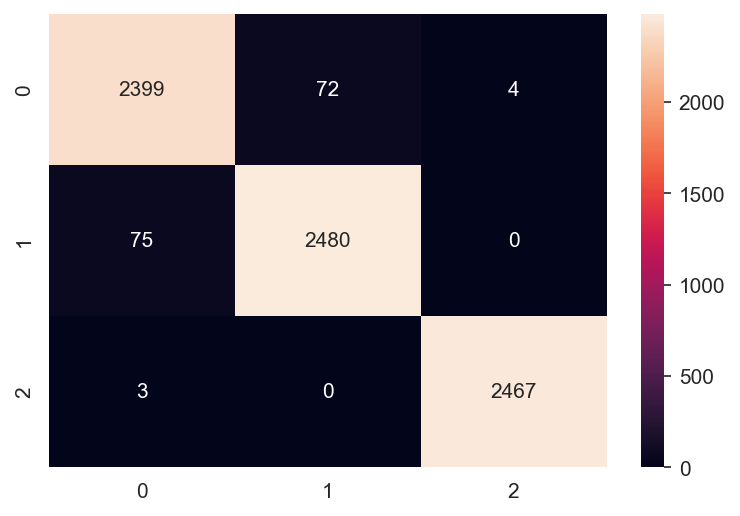

In [199]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='0.0f')

### Random Forest

In [200]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [201]:

y_pred = rfc.predict(X_test)

In [202]:

y_pred_train = rfc.predict(X_train)

In [203]:
from sklearn import metrics
print("Train ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred_train))

Train ACCURACY OF THE MODEL:  1.0


In [204]:
from sklearn import metrics
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9873333333333333


In [205]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2475
           1       0.99      0.97      0.98      2555
           2       1.00      1.00      1.00      2470

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



In [206]:
confusion_matrix(y_test, y_pred)

array([[2448,   18,    9],
       [  67, 2488,    0],
       [   1,    0, 2469]], dtype=int64)

<AxesSubplot:>

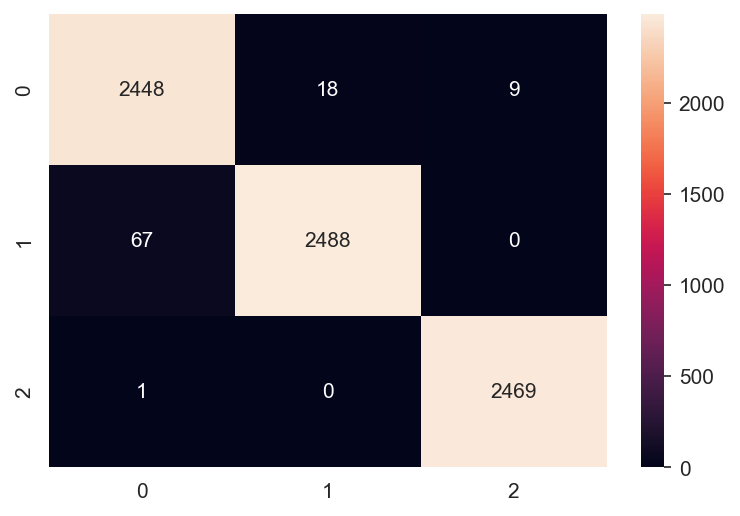

In [207]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='0.0f')

### SVM


In [208]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 67.65
Time consumed for training: 30.441 seconds
Time consumed for prediction: 12.36345 seconds


In [209]:
from sklearn.metrics import confusion_matrix, classification_report
# generating classification report
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.67      0.65      0.66      2475
           1       0.59      0.71      0.64      2555
           2       0.81      0.67      0.74      2470

    accuracy                           0.68      7500
   macro avg       0.69      0.68      0.68      7500
weighted avg       0.69      0.68      0.68      7500



In [210]:
confusion_matrix(y_test, preds)

array([[1612,  815,   48],
       [ 418, 1803,  334],
       [ 368,  443, 1659]], dtype=int64)

<AxesSubplot:>

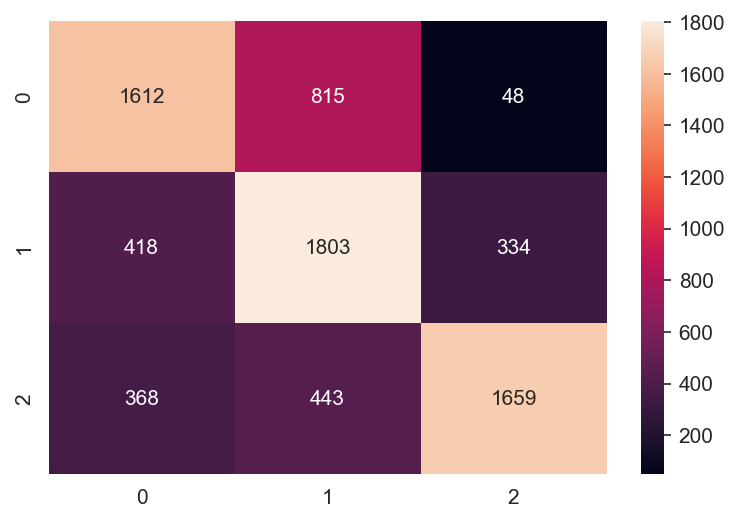

In [211]:
sns.heatmap(confusion_matrix(y_test, preds), annot = True, fmt='0.0f')

### K-nearest Neighbors

In [212]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#### choosing the best values of k (neighbours)

In [213]:
neighbour = []
accuracy = []
for k in range(1, 20):
  k_near = KNeighborsClassifier(n_neighbors=k)
  k_near.fit(X,y)
  Y_pre_test = k_near.predict(X_test)
  Y_pre_train = k_near.predict(X_train)
  test_accurry = accuracy_score(Y_pre_test, y_test)
  neighbour.append(k)
  accuracy.append(test_accurry)

Text(0, 0.5, 'accuracy')

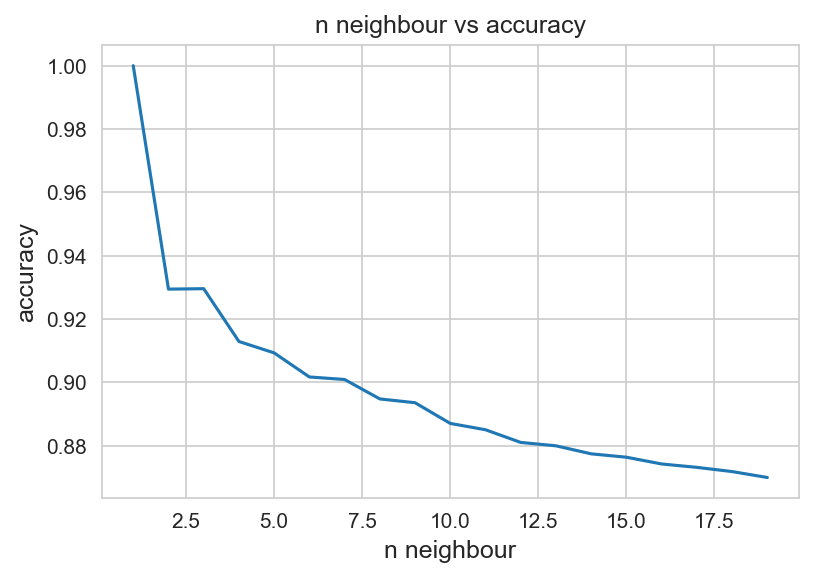

In [214]:
# plotting for n neighbour vs accuracy
plt.plot(neighbour, accuracy)
plt.title('n neighbour vs accuracy')
plt.xlabel('n neighbour')
plt.ylabel('accuracy')

we can see the accuracy is highest for n_neighbours = 1

#### KNN with n_neighbour = 1 

In [215]:
k_near = KNeighborsClassifier(n_neighbors=1)
k_near.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [216]:
Y_pre_test = k_near.predict(X_test)
Y_pre_train = k_near.predict(X_train)

In [217]:
from sklearn.metrics import accuracy_score
train_accurry = accuracy_score(Y_pre_train, y_train)
test_accurry = accuracy_score(Y_pre_test, y_test)
print('Accuracy for train dataset for K-neariest : ', train_accurry)
print('Accuracy for test dataset for K-neariest : ', test_accurry)

Accuracy for train dataset for K-neariest :  1.0
Accuracy for test dataset for K-neariest :  0.8757333333333334


In [218]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, Y_pre_test ))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2475
           1       0.92      0.91      0.91      2555
           2       0.86      0.82      0.84      2470

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



In [219]:
confusion_matrix(y_test, Y_pre_test )

array([[2229,   55,  191],
       [ 107, 2313,  135],
       [ 311,  133, 2026]], dtype=int64)

<AxesSubplot:>

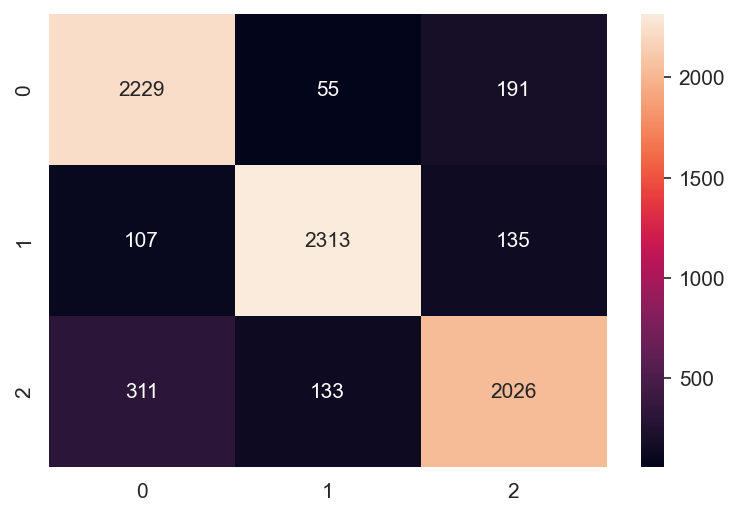

In [220]:
sns.heatmap(confusion_matrix(y_test, Y_pre_test), annot = True, fmt='0.0f')

### Logistic Regression

In [221]:
from sklearn.linear_model import LogisticRegression

In [222]:
lgr = LogisticRegression(random_state=0)
lgr.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [223]:
y_pre_test = lgr.predict(X_test)
y_pre_train = lgr.predict(X_train)

In [224]:
from sklearn.metrics import accuracy_score
train_accurry = accuracy_score(y_pre_train, y_train)
test_accurry = accuracy_score(y_pre_test, y_test)
print('Accuracy for train dataset for logistic reg : ', train_accurry)
print('Accuracy for test dataset for logistic reg : ', test_accurry)

Accuracy for train dataset for logistic reg :  0.6306666666666667
Accuracy for test dataset for logistic reg :  0.6149333333333333


In [225]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pre_test ))


              precision    recall  f1-score   support

           0       0.58      0.77      0.66      2475
           1       0.71      0.48      0.57      2555
           2       0.59      0.60      0.60      2470

    accuracy                           0.61      7500
   macro avg       0.63      0.62      0.61      7500
weighted avg       0.63      0.61      0.61      7500



In [226]:
confusion_matrix(y_test, y_pre_test )

array([[1900,   16,  559],
       [ 874, 1222,  459],
       [ 495,  485, 1490]], dtype=int64)

<AxesSubplot:>

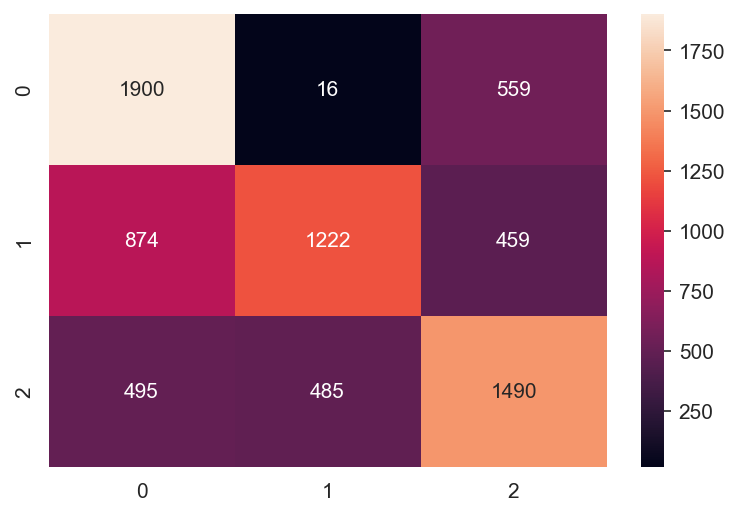

In [227]:
sns.heatmap(confusion_matrix(y_test,y_pre_test), annot = True, fmt='0.0f')

### Naive Bayes

In [228]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB, ComplementNB

In [229]:

nvb = GaussianNB()
nvb.fit(X_train,y_train)

GaussianNB()

In [230]:
y_pre_test = nvb.predict(X_test)
y_pre_train = nvb.predict(X_train)

In [231]:
from sklearn.metrics import accuracy_score
train_accurry = accuracy_score(y_pre_train, y_train)
test_accurry = accuracy_score(y_pre_test, y_test)
print('Accuracy for train dataset for naive bayes  reg : ', train_accurry)
print('Accuracy for test dataset for naive bayes reg : ', test_accurry)

Accuracy for train dataset for naive bayes  reg :  0.8702666666666666
Accuracy for test dataset for naive bayes reg :  0.8645333333333334


In [232]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pre_test ))


              precision    recall  f1-score   support

           0       0.77      0.90      0.83      2475
           1       0.96      0.92      0.94      2555
           2       0.88      0.77      0.82      2470

    accuracy                           0.86      7500
   macro avg       0.87      0.86      0.86      7500
weighted avg       0.87      0.86      0.87      7500



In [233]:
confusion_matrix(y_test, y_pre_test)

array([[2235,   18,  222],
       [ 187, 2341,   27],
       [ 484,   78, 1908]], dtype=int64)

<AxesSubplot:>

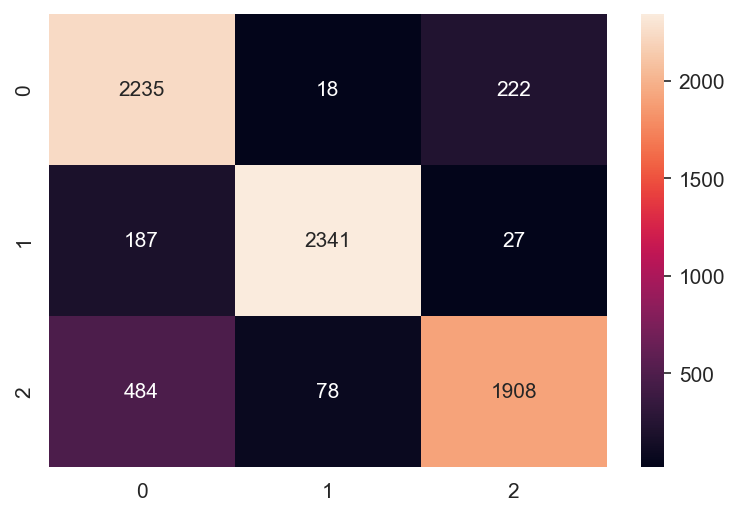

In [234]:
sns.heatmap(confusion_matrix(y_test, y_pre_test), annot = True, fmt='0.0f')

### Adaboost

In [235]:
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(n_estimators=100, random_state=42)


clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [236]:
clf.score(X_train, y_train)

0.8642666666666666

In [237]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.862


In [238]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2475
           1       0.81      0.93      0.87      2555
           2       0.99      0.89      0.94      2470

    accuracy                           0.86      7500
   macro avg       0.87      0.86      0.86      7500
weighted avg       0.87      0.86      0.86      7500



<AxesSubplot:>

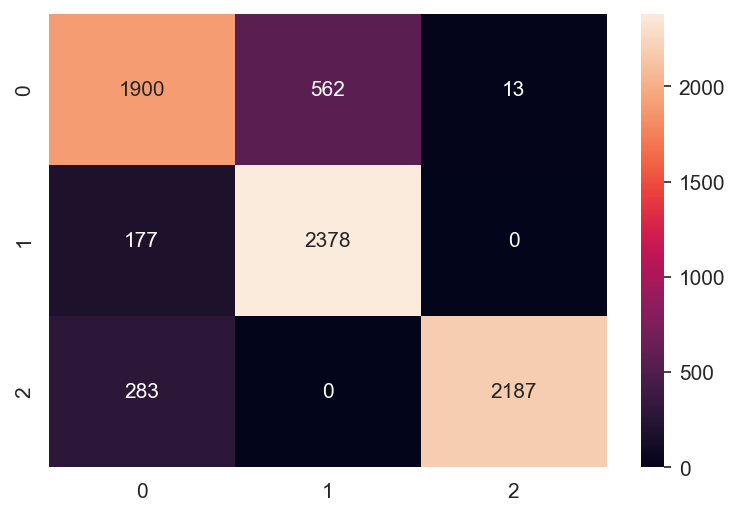

In [239]:
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='0.0f')

**<H2>Hybrid Ensembler</h2>**

**Ensembler method used** - **Max voting:** It is mainly used for classification problems. The method consists of building multiple models independently and getting their individual output called ‘vote’. The class with maximum votes is returned as output. 

In [240]:

from sklearn.ensemble import VotingClassifier

In [241]:
model_1 = RandomForestClassifier(n_estimators=100)
model_2 = KNeighborsClassifier(n_neighbors=1)
model_3 = LogisticRegression(random_state=0)
model_4 = GaussianNB()
model_5 = DecisionTreeClassifier()
ensemble = VotingClassifier(estimators=[('RandomForest', model_1), ('KNN', model_2), ('LogisticRegression', model_3), ('NaiveBayes', model_4),
                                        ('DT', model_5)], voting='hard')

In [242]:
ensemble.fit(X_train, y_train)
y_pred_test = ensemble.predict(X_test)
y_pred_train = ensemble.predict(X_train)

In [243]:
from sklearn.metrics import accuracy_score
train_accurry = accuracy_score(y_pred_train, y_train)
test_accurry = accuracy_score(y_pred_test, y_test)
print('Accuracy for train dataset : ', train_accurry)
print('Accuracy for test dataset', test_accurry)

Accuracy for train dataset :  1.0
Accuracy for test dataset 0.9512


In [244]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(ensemble, open(filename, 'wb'))